# Preprocessing for Neural Network
### Finalized 5/9/24

## Summary

Multiple datasets were created to document combinations of null-threshold filtering and target variable balancing applied to the BRFSS Kaggle dataset.

| Operation | Parameters | Notes | Filename |
|---|---|---|---|
|Null-Threshold Filtering|0, 1, 3, 5, 10, 20, 40| 0 = No missing and 40 = all missing |---|
|Random Over Sampling (n:y)| 1:1, 1:2, 1:3, 1:5, 1:7 | Randomly select CVD observations with replacement |---|
|Random Under Sampling (n:y)| 1:1, 2:1, 3:1, 5:1, 7:1 | Randomly remove Healthy observations |---|
|Baseline test sets| 7 (14 files) | Null-threshold datasets without over/under sampling | `df_heart_drop_[threshold]_imp_[X/y]_test`|
|Baseline Training Sets | 7 (14 files) | Null-threshold datasets without over/under sampling | `df_heart_drop_[threshold]_imp[X/y]_train`|
|Preprocessing Training Sets| 70 (140 files) | Null-threshold * (Under + Over) sampling | `[Over/Under]_Sample_[ratio]-_threshold_[threshold]_[X/y]_train`|
|Total datasets| 84 (168 files) | All datasets are imputed and encoded but not standardized.| All files are in parquet format in `./Data/GoogleDrive/Encoded_Data/`|

## Table of Contents

- [Notebook Setup](#Notebook-Setup)
- [Read in Parquet](#Read-in-Parquet)
- [Encode Features](#Encode-Features)
- [Balance Target Features](#Balance-Target-Features)
- [Results](#Results)
- [Save as Parquet](#Save-as-Parquet)

## Notebook Setup

Significant functions used can be found in [assignment_3_tools.py](./assignment_3_tools.py)

 To Run this notebook __100GB of ram/swap__ is required until the notebook is optimized by iterative reading, encoding, and balancing are used.

In [1]:
from app_tools import (
    parquet_to_dict,
    pickle_to_dict,
    encode_cvd_var, #hailey's
    load_and_transform_new_data #not used
)
import polars as pl
import pandas as pd

## Read in Parquet

Read in all null-threshold datasets

In [2]:
%%time
pq_jar = parquet_to_dict('../../Data/GoogleDrive/Assignment_2_Archive/') #lazy read all parquet

thresholds = [20]
all_heart_drop = dict()

# Select all drop threshold datasets and convert to pandas
for threshold in thresholds:
    df_name = f"df_heart_drop_{threshold:02}_imp"
    all_heart_drop[df_name] = pq_jar[df_name].collect().to_pandas()

CPU times: user 453 ms, sys: 151 ms, total: 603 ms
Wall time: 331 ms


In [3]:
pq_jar['df_heart_drop_20_imp'].collect().to_pandas()['State'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Guam', 'Puerto Rico',
       'Virgin Islands'], dtype=object)

## Encode Features

Encode all null-threshold datasets. Encoding operations from [`encode_cvd_varencode_cvd_var()`](./assignment_3_tools.py) were applied to all null-thresholds.

In [4]:
%%time
split_encoded = dict()
# Encode all null-threshold datasets
for key, value in all_heart_drop.items():
    X_train = f"{key}_X_train"
    X_test = f"{key}_X_test"
    y_train = f"{key}_y_train"
    y_test = f"{key}_y_test"
    (split_encoded[X_train], 
     split_encoded[X_test], 
     split_encoded[y_train], 
     split_encoded[y_test]) = encode_cvd_var(value)

CPU times: user 2.07 s, sys: 302 ms, total: 2.37 s
Wall time: 2.42 s


## Balance Target Features

Balance all null-threshold datasets.

/opt/anaconda3/envs/203C/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/203C/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/203C/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


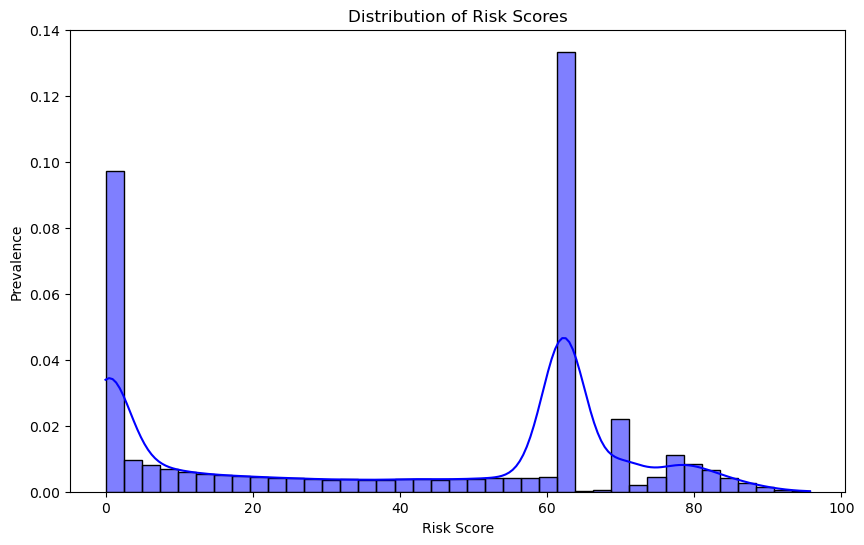

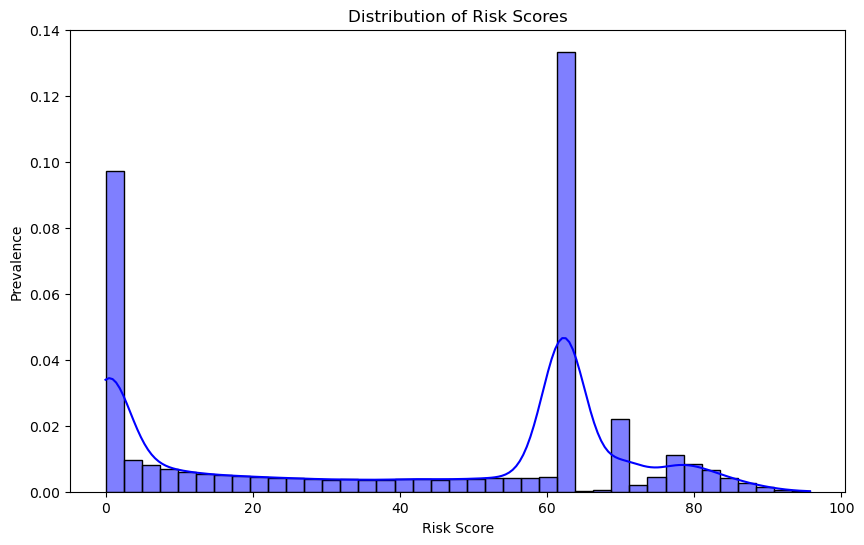

In [38]:
from shiny import App, ui, render
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import io
from PIL import Image
from shiny import App, render, ui, reactive
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from shinyswatch import theme
from app_tools import pickle_to_dict
import pickle

pq_dict = parquet_to_dict('../models/')

popdata = pq_dict['df_heart_drop_20_imp_X_test'].collect().to_pandas().drop('__index_level_0__', axis=1)

pickle_dict = pickle_to_dict('../models/')

pipeline = Pipeline(steps=[
    ('scaler', pickle_dict['standard_scaler']),
    ('model', pickle_dict['best_model'])
])

poppred = pipeline.predict_proba(popdata)[:, 1] * 100

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(poppred, kde=True, color='blue', stat='density', ax=ax)
#ax.axvline(individual_risk_score, color='red', linestyle='-', linewidth=2)
#ax.text(individual_risk_score + 1, 0.02, 'You are here', color='red', rotation=90)
ax.set_title('Distribution of Risk Scores')
ax.set_xlabel('Risk Score')
ax.set_ylabel('Prevalence')

with open('../models/pop_plot.pkl', 'wb') as file:
            pickle.dump(fig, file)
with open('../models/pop_pred_data.pkl', 'wb') as file:
            pickle.dump(poppred, file)

In [8]:
%%time
ratios = [1]
balanced_X_trains = dict()
balanced_y_trains = dict()

# Apply Balancing to all null-threshold datasets
for key in all_heart_drop:
    X_train = split_encoded[f"{key}_X_train"]
    y_train = split_encoded[f"{key}_y_train"]
    for ratio in ratios:
        (balanced_X_trains[f"Over_Sample_1:{ratio}_threshold_{key[-6:-4]}_X_train"], 
         balanced_y_trains[f"Over_Sample_1:{ratio}_threshold_{key[-6:-4]}_y_train"]) = rand_over_sample(X_train, y_train, ratio)
        (balanced_X_trains[f"Under_Sample_{ratio}:1_threshold_{key[-6:-4]}_X_train"], 
         balanced_y_trains[f"Under_Sample_{ratio}:1_threshold_{key[-6:-4]}_y_train"]) = rand_over_sample(X_train, y_train, ratio)

KeyError: 'df_heart_drop_20_imp_X_train'

## Results

- [x] Make a table of over/under sampled datasets
- [] Add MLP performance

In [10]:
%%time
Balance_Method = list()
No_CVD = list()
Yes_CVD = list()
Total_Obs = list()

for key, value in balanced_y_trains.items():
    Balance_Method.append(key[:-8])
    No_CVD.append(value.value_counts()[0])
    Yes_CVD.append(value.value_counts()[1])
    Total_Obs.append(value.value_counts()[1] + value.value_counts()[0])

tbl_balanced = pd.DataFrame({
    'Balance_Method': Balance_Method,
    'No_CVD': No_CVD,
    'Yes_CVD': Yes_CVD,
    'Total_Obs': Total_Obs})

GT(tbl_balanced.sort_values(by='Balance_Method', ascending=True))

CPU times: user 54 ms, sys: 8.63 ms, total: 62.7 ms
Wall time: 66 ms


Balance_Method,No_CVD,Yes_CVD,Total_Obs
Over_Sample_1:1_threshold_20,290589,290589,581178
Under_Sample_1:1_threshold_20,290589,290589,581178


## Save as Parquet

In [7]:
%%time
pd_dict_to_parquet(balanced_X_trains, "../../Data/GoogleDrive/Encoded_Data/")
pd_dict_to_parquet(balanced_y_trains, "../../Data/GoogleDrive/Encoded_Data/")
pd_dict_to_parquet(split_encoded, "../../Data/GoogleDrive/Encoded_Data/")
tbl_balanced.to_parquet("../../Data/GoogleDrive/tbl_of_balanced.parquet")

CPU times: user 1min 52s, sys: 1min 2s, total: 2min 55s
Wall time: 2min 27s
